** Artem Zaika: KDD Cup 2009 - Customer relationship prediction **

For the study data were taken from the competition KDD 2009 on [Customer Relationship prediction](http://www.kdd.org/kdd-cup/view/kdd-cup-2009/Data)

### Task Description

The task is to estimate the churn of customers, hence there are two target values to be predicted. The challenge is staged in phases to test the rapidity with which each team is able to produce results. A large number of variables (15,000) is made available for prediction. However, to engage participants having access to less computing power, a smaller version of the dataset with only 230 variables will be made available in the second part of the challenge.

Churn (wikipedia definition): Churn rate is also sometimes called attrition rate. It is one of two primary factors that determine the steady-state level of customers a business will support. In its broadest sense, churn rate is a measure of the number of individuals or items moving into or out of a collection over a specific period of time. The term is used in many contexts, but is most widely applied in business with respect to a contractual customer base. For instance, it is an important factor for any business with a subscriber-based service model, including mobile telephone networks and pay TV operators. The term is also used to refer to participant turnover in peer-to-peer networks.

The small dataset will be made available at the end of the fast challenge. Both training and test sets contain 50,000 examples. The data are split similarly for the small and large versions, but the samples are ordered differently within the training and within the test sets. Both small and large datasets have numerical and categorical variables. For the large dataset, the first 14,740 variables are numerical and the last 260 are categorical. For the small dataset, the first 190 variables are numerical and the last 40 are categorical. Toy target values are available only for practice purpose. The prediction of the toy target values will not be part of the final evaluation.

### Evaluation

The performances are evaluated according to the arithmetic mean of the AUC for the hurn. This is what we call "Score".

## 1. Introduction

My work will be divided into several parts:
* <a href="#2.-The-primary-analysis-of-the-features,-identifying-patterns-in-distributions">2. The primary analysis of the features, identifying patterns in distributions</a>
    * <a href="#2.1-Numerical-features">2.1 Numerical features</a>
    * <a href="#2.2-Categorical-features">2.2 Categorical features</a>
* <a href="#3.-Working-with-features,-processing-of-missing-values">3. Working with features, processing of missing values</a>
    * <a href="#3.1-Evaluation-of-the-quality-of-the-model-depending-on-the-number-of-objects">3.1 Evaluation of the quality of the model depending on the number of objects</a> 
    * <a href="#3.2-The-elimination-of-the-imbalance-of-classes-by-increasing-the-number-of-objects-of-a-smaller-class">3.2 The elimination of the imbalance of classes by increasing the number of objects of a smaller class</a>
    * <a href="#3.3-The-elimination-of-the-imbalance-of-classes-by-reducing-the-number-of-objects-larger-class">3.3 The elimination of the imbalance of classes by reducing the number of objects larger class</a>
    * <a href="#3.4-Blanks-filling-for-object-separately-by-class">3.4 Blanks-filling for object separately by class</a>
    * <a href="#3.5-Comparison-of-strategies-for-encoding-categorical-features">3.5 Comparison of strategies for encoding categorical features</a>
* <a href="#4.-Features-analysis,-selection-of-features">4. Features analysis, selection of features</a>
* <a href="#5.-Model-customizing">5. Model customizing</a>
    * <a href="#5.1-Investigation-of-objects-that-achieved-the-highest-classification-error">5.1 Investigation of objects that achieved the highest classification error</a>
* <a href="#6.-Future-improvements">6. Future improvements</a>

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import xgboost as xgb
from statsmodels.stats.weightstats import *
from statsmodels.stats.proportion import proportion_confint
from scipy import stats

from collections import defaultdict, Counter
import itertools
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import SelectKBest,RFECV, SelectFromModel
from sklearn.feature_selection import mutual_info_classif,  f_classif
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import validation_curve, learning_curve
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit, StratifiedKFold

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

seed = 123
np.random.seed(seed)

In [2]:
xgb.__version__

'0.4'

** Сonduct primary data analysis. Look at the data validity and omissions**

In [3]:
df = pd.read_csv('orange_small_churn_train_data.csv', index_col='ID')
df.head()

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,...,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230,labels
ID,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,3052.0,NaN,NaN,NaN,NaN,...,vr93T2a,LM8l689qOp,NaN,NaN,fKCe,02N6s8f,xwM2aC7IdeMC0,NaN,NaN,-1
1,NaN,NaN,NaN,NaN,NaN,1813.0,7.0,NaN,NaN,NaN,...,6hQ9lNX,LM8l689qOp,NaN,ELof,xb3V,RAYp,55YFVY9,mj86,NaN,-1
2,NaN,NaN,NaN,NaN,NaN,1953.0,7.0,NaN,NaN,NaN,...,catzS2D,LM8l689qOp,NaN,NaN,FSa2,ZI9m,ib5G6X1eUxUn6,mj86,NaN,-1
3,NaN,NaN,NaN,NaN,NaN,1533.0,7.0,NaN,NaN,NaN,...,e4lqvY0,LM8l689qOp,NaN,NaN,xb3V,RAYp,F2FyR07IdsN7I,NaN,NaN,1
4,NaN,NaN,NaN,NaN,NaN,686.0,7.0,NaN,NaN,NaN,...,MAz3HNj,LM8l689qOp,NaN,NaN,WqMG,RAYp,F2FyR07IdsN7I,NaN,NaN,-1


** For convenience, replace the target variable with the label -1 (churn) on 0**

In [4]:
df.loc[df['labels'] == -1, 'labels'] = 0

** As we see in the data a lot of missing values. There are also features, which have missed all the values. When recovery permits, it is important to have a reliable allocation, but if the blanks in features of more than 60%, then I think such a distribution can not be trusted and means to restore such signs are useless, because they introduce only noise in the model**

** Remove features of having gaps in more than 65% of cases**

In [5]:
def drop_empty(df):
    has_nan = df.isnull().sum()
    empty_cols = has_nan[has_nan >= len(df) * 0.65]
    to_drop = empty_cols.index.values.tolist()

    df.drop(to_drop, axis=1, inplace = True)
    return df

df = drop_empty(df)
df.head()

,Var6,Var7,Var13,Var21,Var22,Var24,Var25,Var28,Var35,Var38,...,Var220,Var221,Var222,Var223,Var225,Var226,Var227,Var228,Var229,labels
ID,,,,,,,,,,,,,,,,,,,,,
0,3052.0,NaN,NaN,480.0,600.0,20.0,480.0,200.00,0.0,82752.0,...,hLKtJ9p,Al6ZaUT,vr93T2a,LM8l689qOp,NaN,fKCe,02N6s8f,xwM2aC7IdeMC0,NaN,0
1,1813.0,7.0,636.0,212.0,265.0,2.0,128.0,166.56,0.0,2706120.0,...,hN8KpA1,oslk,6hQ9lNX,LM8l689qOp,ELof,xb3V,RAYp,55YFVY9,mj86,0
2,1953.0,7.0,448.0,176.0,220.0,0.0,72.0,311.76,0.0,4698780.0,...,4UxGlow,zCkv,catzS2D,LM8l689qOp,NaN,FSa2,ZI9m,ib5G6X1eUxUn6,mj86,0
3,1533.0,7.0,4.0,332.0,415.0,0.0,144.0,220.08,5.0,864384.0,...,ylCK5YS,oslk,e4lqvY0,LM8l689qOp,NaN,xb3V,RAYp,F2FyR07IdsN7I,NaN,1
4,686.0,7.0,0.0,160.0,200.0,2.0,48.0,278.00,0.0,4364880.0,...,PYpzAu9,oslk,MAz3HNj,LM8l689qOp,NaN,WqMG,RAYp,F2FyR07IdsN7I,NaN,0


In [6]:
data, labels = df.iloc[:, :-1], df.iloc[:,-1]

** Calculate proporions of classes “churn” and “not churn”. **

In [29]:
length = data.shape[0]
label_counts = labels.value_counts()

print 'Proporion of class “not churn”:', float(label_counts[0]) / length
print 'Proporion of class “churn”:', float(label_counts[1]) / length

Proporion of class “not churn”: 0.9256
Proporion of class “churn”: 0.0744


** As we see, proportion of classes 1 is more than proportion of class 0, in almost 130 times. It's not good as for classification it is important that classes in the sample were balanced. Ie in our case the number of labels class 1 - 'not churn', the proportion must be equal to the number of tags of class 0 - 'churn'. If the balance is skewed toward larger class, models, especially linear, can be too retrained to detect class with higher proportion and ignore the small one.**

**Later on we will continue to conduct experiments to increase number of objects of smaller class and see how it will affect the model evaluation.**

## 2. The primary analysis of the features, identifying patterns in distributions

**There are two types of features in our sample- real and categorical. Separate them and, by default, fill in the blanks in the numerical features with zeros and categorical features with string - 'NaN' **

In [8]:
num_features = data.select_dtypes(include=['float64', 'int64']).columns
cat_features = data.select_dtypes(include=['object']).columns

data[num_features] = data[num_features].fillna(0)
data[cat_features] = data[cat_features].fillna('NaN')

** Evaluate the density distribution of the classes. This will allow first, to assess the type of distribution(this can be useful when restoring blanks), and the ratio of distributions of features for different classes. **

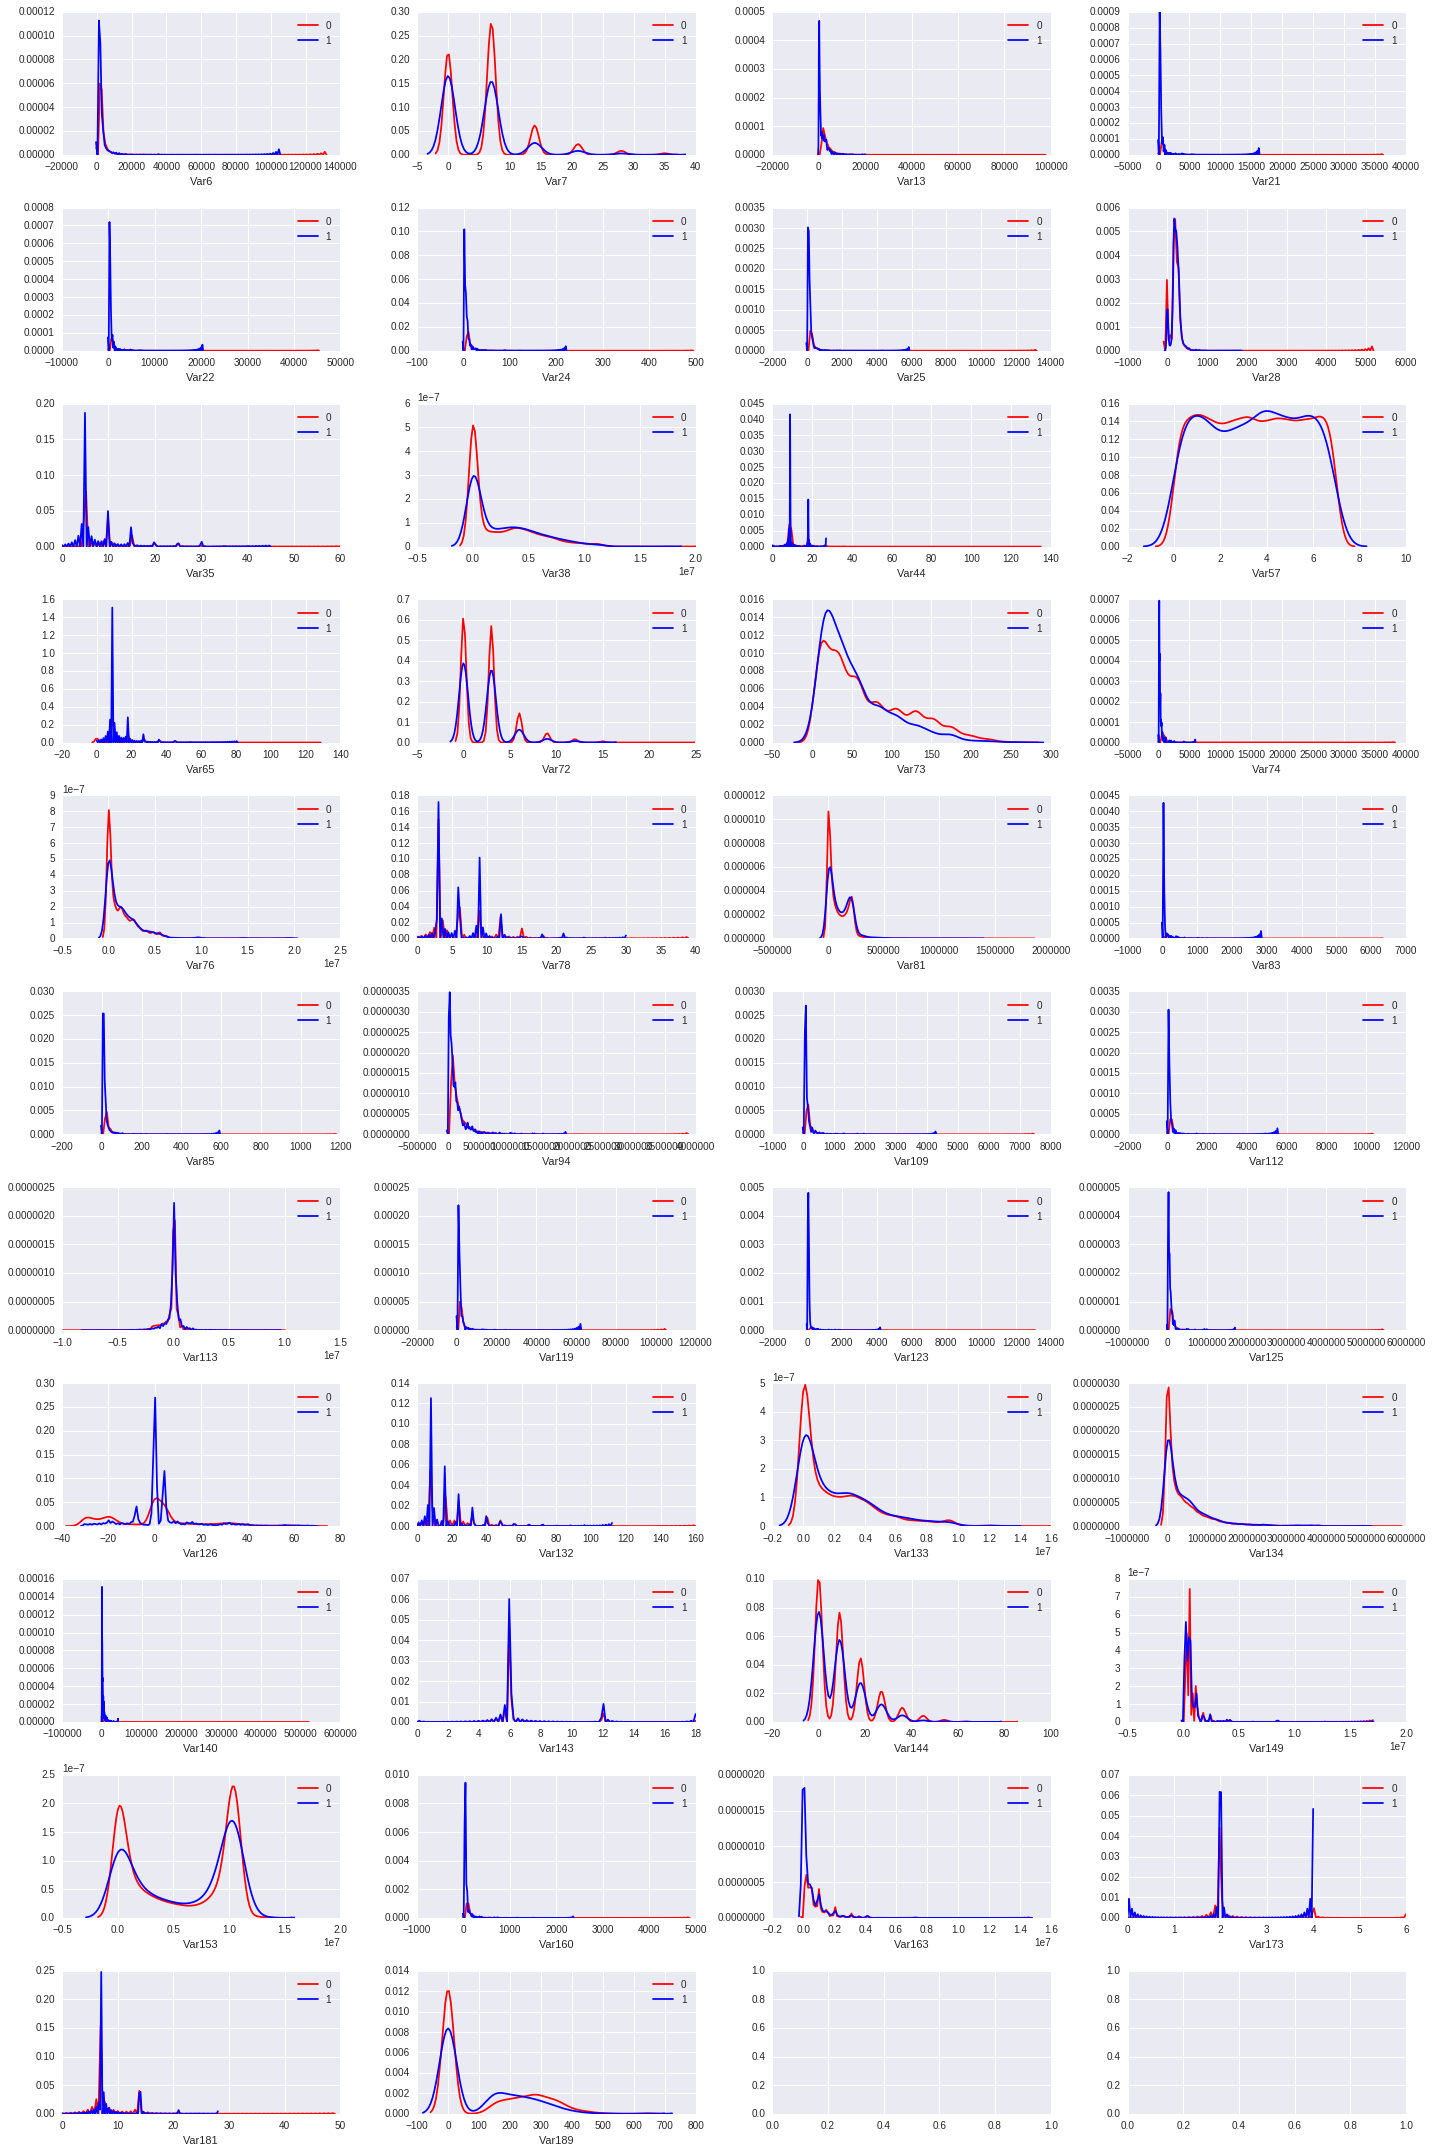

In [9]:
fig, axes = plt.subplots(11, 4, figsize=(20, 30))
for i in xrange(len(num_features)):
    sns.kdeplot(data.loc[labels == 0, num_features[i]], color = 'r', ax=axes[i / 4, i % 4], label=0)
    sns.kdeplot(data.loc[labels == 1, num_features[i]], color = 'b', ax=axes[i / 4, i % 4], label=1)
    axes[i / 4, i % 4].set(xlabel=num_features[i])
fig.tight_layout()

** So, what can we say about the densities of the distributions? They do not belong to a normal distribution and some distribution, for example Var189, Var73, Var126 clearly suggests that the distribution of classes 0 and 1 for these features are different, so could correlate differently with the target label**

Why I started talking about the correlation between the features and target label. The thing is that in the calculation of dependencies of target labels from features, it is highly desirable to do so, so the features are poorly correlated among themselves, but were highly correlated with the target label. If features are not highly correlated with the target label, it is indicative of their usefulness in prediction. If the features correlate strongly with each other, it suggests redundancy and can negative affect the quality of prediction. Thus, highly correlated features can be simplified or somehow express each other and it can have a positive effect in forecasting.

#### 2.1 Numerical features

Because the target variable is binary (classes do not churn/churn), will not fit the calculation of the Pearson correlation (or any other), so calculate the difference of mathematical expectation of feature for both classes of the target variable. Distribution of numerical features can be very different (see below), so as a measure of relatedness between the target variable and the feature will be used the significance level of the hypothesis that the characteristic distribution for both classes (the target variable) are the same. Using the Mann-Whitney test get that the mathematical expectation of 24 features for both classes are different at significance level 0.01:

In [10]:
# check whether average is significantly different for both classes in each feature
pvals = []
for i, col_name in enumerate(num_features):
    class0 = data.loc[labels == 0, col_name]
    class1 = data.loc[labels == 1, col_name]
    
    pvals.append(stats.mannwhitneyu(class0, class1)[1])

pvals_df = pd.DataFrame({'p_value': pvals}, index=num_features).sort_values('p_value', ascending=True)

# the number of variables that have statistically significantly different average
sum(pvals_df['p_value'] < 0.01)

24

In [91]:
top20 = pvals_df[:20].index.tolist()
pvals_df.head()

,p_value
Var74,1.712714e-48
Var13,3.932649e-36
Var73,5.239055e-33
Var7,1.029381e-31
Var140,1.835457e-31


Graphs of the density distributions of the first 8 most different features(the weakest correlated) depending on the target variable:

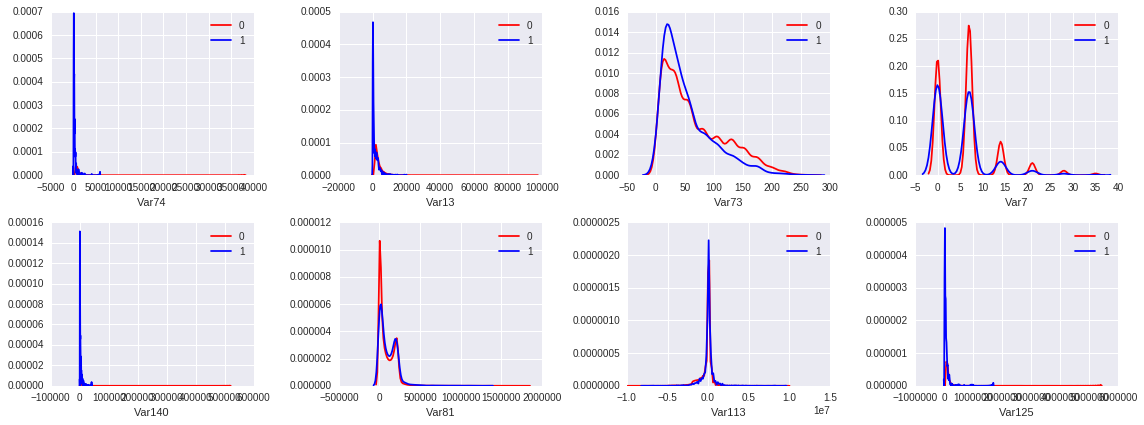

In [92]:
fig, axes = plt.subplots(2, 4, figsize=(16, 6))
for i in range(8):
    sns.kdeplot(data.loc[labels == 0, pvals_df.index[i]], color = 'r', ax=axes[i / 4, i % 4], label=0)
    sns.kdeplot(data.loc[labels == 1, pvals_df.index[i]], color = 'b', ax=axes[i / 4, i % 4], label=1)
    axes[i / 4, i % 4].set(xlabel=pvals_df.index[i])
fig.tight_layout()

Numeric features have a lot of blanks, so the lack of values in a numeric variable can also be a good marker-feature for the model. For example, one of the previous feature, Var126, we compare the proportion of positive class for the whole sample and among the missing values of the feature Var126:

In [27]:
print "Proportion of class churn", float(label_counts[1]) / length

print "Proportion of class churn for missed values of feature Var126:", np.round(labels[df.Var126.isnull()].mean(), 3)

Proportion of class churn 0.0744
Proportion of class churn for missed values of feature Var126: 0.113


To be sure that the proportions differ significantly, considering a confidence interval of Wilson for the fraction of missing values of the characteristic Var126:

In [28]:
proportion = labels[df.Var126.isnull()].mean() 
n = sum(df.Var126.isnull())
print "Confidence interval:", np.round(proportion_confint(proportion*n, n, alpha = 0.05, method="wilson"), 4)

Confidence interval: [ 0.1068  0.1185]


#### 2.2 Categorical features

Categorical variables are very different, some of them has 10 to >13 thousand unique values. To check which of the variables can be useful for us let's calculate for each unique value of a categorical feature the proportion of positive class, and construct a confidence interval for this proportion. If the proportion of the original dataset is missing in the interval, then this feature (with these unique values) may be useful for the model.

In [95]:
# the Cramer's correlation coefficient for categorical variables
# http://stackoverflow.com/questions/20892799/using-pandas-calculate-cramérs-coefficient-matrix
def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))


# wrapper for the function above
def get_cramers_cor(var1, var2):
    if var1.equals(var2):
        return 1.0
    confusion_matrix = pd.crosstab(var1, var2)
    return cramers_corrected_stat(np.array(confusion_matrix))

# build Wilson's confidence interval and check whether basline belongs to it
def in_conf_int(baseline, proportion, n, alpha = 0.05):
    conf_int = proportion_confint(proportion*n, n, alpha = alpha, method="wilson")
    if baseline > conf_int[0] and baseline < conf_int[1]:
        return True
    return False

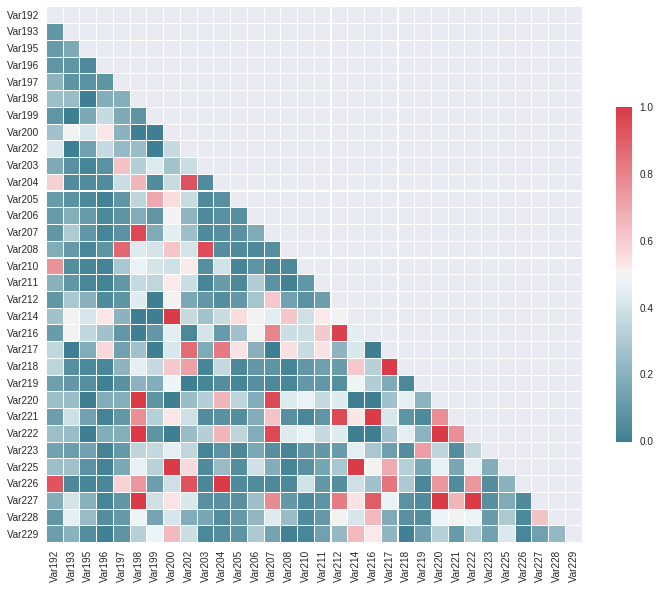

In [96]:
# calculate correlations
conf_matrix_cor = pd.DataFrame(1.0, index=cat_features, columns=cat_features)
for feat in itertools.combinations(cat_features, 2):
    conf_matrix_cor.loc[feat[0], feat[1]] = get_cramers_cor(data[feat[0]], data[feat[1]])
    conf_matrix_cor.loc[feat[1], feat[0]] = conf_matrix_cor.loc[feat[0], feat[1]]

# triangle mask
mask = np.zeros_like(conf_matrix_cor, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# plot params
f, ax = plt.subplots(figsize=(12, 12))

# palette
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# heat-map drawing
sns.heatmap(conf_matrix_cor, mask=mask, cmap=cmap, vmax=1.0, vmin=0.0,
            square=True, xticklabels=True, yticklabels=True,
            linewidths=.1, cbar_kws={"shrink": .5}, ax=ax)
plt.show()

**Conclusions:** So, we conducted primary data analysis and identified features and categorially features that can have the greatest impact on prognosis. Such analysis can be very useful when working with linear models, but when working with Trees, RandomForest and Gradient Boosting models, it may not be very useful, because these models in the preview are not sensitive to distortions in classes, and secondly use a different approach in assessing the importance of features(the so-called 'information gain').

## 3. Working with features, processing of missing values

Hereafter, I will use the model gradient boosting - XGBoost. It will have some influence on the data, such as:
   * Gradienty boosting is not sensitive to the difference in scale of feature values. That is, the feature can contain the values 1 and 1000 and they do not need to be scaled, as in the case of linear models.
   * Gradienty boosting in its own way determines which features to use to make the split. Sometimes these features are not very good and you need to help boosting to find useful features to split, such as adding new feature showing if feature has blanks. For categorical features - adding new feature, coded by categories frequency 

** Make some utility functions for visualization of cross-validation results of XGBoost.**

In [32]:
# Graph results sklearn.model_selection.learning_curve
def plot_curves(train_scores, test_scores, train_sizes, x_text="num of samples"):    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fig = plt.figure(figsize=(10, 6), dpi=100)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.xlabel(x_text)
    plt.ylabel("score")
    plt.legend(loc="best")
    plt.show()
    
    i = np.argmax(test_scores_mean)
    print("Best cross-validation result ({0:.2f}) obtained for {1} ".format(test_scores_mean[i], train_sizes[i]))
    
# visualize score depending on number of objects 
def train_learning_curve(X_train, y_train, default_params=None):
    scale_pos_weight = float(sum(y_train == 0))/sum(y_train == 1)
        
    if default_params is None:
        default_params = {
            'objective': 'binary:logistic',
            'max_depth': 2,
            'learning_rate': 0.3,
            'silent': 1.0,
            'scale_pos_weight':scale_pos_weight,
            'n_estimators':23,
            'seed': seed
            }
        
    default_params['scale_pos_weight'] = scale_pos_weight
    train_sizes, train_scores, valid_scores = learning_curve(
        xgb.XGBClassifier(**default_params), 
        X_train, y_train,        
        scoring='roc_auc', 
        cv=StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=seed), n_jobs=-1)
    
    
    plot_curves(train_scores, valid_scores, train_sizes) 
    
# Score - number of algorithms dependency visualizaion    
def train_validation_curve(X_train, y_train, est_end=200, default_params=None):
    scale_pos_weight = float(sum(y_train == 0))/sum(y_train == 1)
    
    if default_params is None:
        default_params = {
            'objective': 'binary:logistic',
            'max_depth': 2,
            'learning_rate': 0.3,
            'silent': 1.0,
            'scale_pos_weight':scale_pos_weight,
            'seed': seed
            }
        
    default_params['scale_pos_weight'] = scale_pos_weight    
    n_estimators_range = np.linspace(1, est_end, 10).astype('int')

    train_scores, test_scores = validation_curve(
        xgb.XGBClassifier(**default_params),
        X_train, y_train,
        param_name = 'n_estimators',
        param_range = n_estimators_range,
        cv=5,
        scoring='roc_auc', n_jobs=-1)
    
    plot_curves(train_scores, test_scores, n_estimators_range, x_text="num of trees")
    
# Cross-validation
def cross_validation(train, labels, default_params=None, num_rounds=23): # how many estimators 
    scale_pos_weight = float(sum(labels == 0))/sum(labels == 1)
    
    if default_params is None:
        default_params = {'objective': 'binary:logistic',
                  'max_depth': 2,
                  'learning_rate': 0.3,
                  'seed': seed}

    default_params['scale_pos_weight'] = scale_pos_weight    
    dtrain = xgb.DMatrix(data=train, label=labels, silent=False, feature_names=train.columns)
    cv_results = xgb.cv(default_params, 
              dtrain, 
              num_boost_round=num_rounds, 
              nfold=5, 
              metrics=['auc'], 
#               shuffle=True, 
#               stratified=True,
              early_stopping_rounds=5,
              seed=seed)

    return cv_results

** It's time to create a delayed sample. It will be a wet towel on your face, when success hit the head due to the fact that you(or rather I) will obtain estimates for roc_auc=1.0.**

** There is one more thing that we need to consider. Models in Machine Learning can only work with numeric values, but not with text data. So we need to convert categorical features to numerical. The basic approach - we will encode all the blanks in the physical signs to 0, in the categorical - 'NaN' and range them using LabelEncoder().**

In [30]:
data[cat_features] = data[cat_features].fillna('NaN').apply(lambda x: LabelEncoder().fit_transform(x))

X_train, X_hold_out, y_train, y_hold_out = train_test_split(data, labels, test_size=0.25, 
                                                     random_state=seed, stratify=labels) 

print 'Any missing values? ', X_hold_out.isnull().values.any()

Any missing values?  False


In [31]:
X_train.head()

,Var6,Var7,Var13,Var21,Var22,Var24,Var25,Var28,Var35,Var38,...,Var219,Var220,Var221,Var222,Var223,Var225,Var226,Var227,Var228,Var229
ID,,,,,,,,,,,,,,,,,,,,,
22182,1106.0,7.0,92.0,168.0,210.0,0.0,48.0,286.96,0.0,3698856.0,...,11,498,4,1781,0,1,4,2,8,1
11748,630.0,0.0,0.0,544.0,680.0,0.0,264.0,253.52,0.0,462420.0,...,11,516,4,2402,0,1,11,2,8,0
1213,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,11,1569,4,704,0,1,18,2,8,0
21427,385.0,21.0,4816.0,144.0,180.0,0.0,8.0,240.56,0.0,2019852.0,...,11,2004,4,3519,0,1,16,2,2,2
33828,763.0,7.0,10072.0,136.0,170.0,0.0,24.0,310.32,0.0,4883400.0,...,11,3352,4,2502,0,2,2,2,14,2


** The data is normal view now, let's first find the desired number of algorithms in xgboost. This is necessary in order not to waste time building unnecessary algorithms and thus to speed up the model training. Put the maximum range is 100. Leave other parameters by default. **

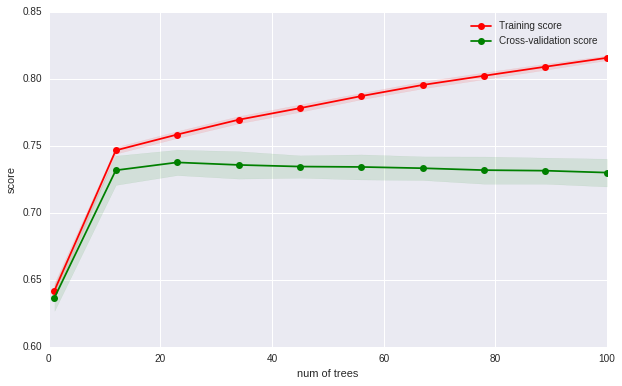

Best cross-validation result (0.74) obtained for 23 


In [123]:
default_params = {
            'objective': 'binary:logistic',
            'max_depth': 2,
            'learning_rate': 0.3,
            'silent': 1.0,            
            'seed': seed
}

train_validation_curve(X_train, y_train, est_end=100, default_params=default_params)

** As we can see, the highest rating obtained in the number of trees 23. The following tests will use the rounded number of algorithms to 24**

In [37]:
default_params = {'objective': 'binary:logistic',
                  'max_depth': 2,
                  'learning_rate': 0.3,
                  'silent': 1.0,
                  'n_estimators': 24,
                  'seed': seed }

** How to interpret the behavior of the curves in the graphs? Comes to the rescue of the information from the sklearn package: http://scikit-learn.org/stable/modules/learning_curve.html#learning-curve**

Description of validation-curve

> If the training score and the validation score are both low, the estimator will be underfitting. If the training score is high and the validation score is low, the estimator is overfitting and otherwise it is working very well. A low training score and a high validation score is usually not possible

Description of training-curve

> A learning curve shows the validation and training score of an estimator for varying numbers of training samples. It is a tool to find out how much we benefit from adding more training data and whether the estimator suffers more from a variance error or a bias error. If both the validation score and the training score converge to a value that is too low with increasing size of the training set, we will not benefit much from more training data. In the following plot you can see an example: naive Bayes roughly converges to a low score.

> We will probably have to use an estimator or a parametrization of the current estimator that can learn more complex concepts (i.e. has a lower bias). If the training score is much greater than the validation score for the maximum number of training samples, adding more training samples will most likely increase generalization.

To sum up, my goal of visual analysis is to make sure that the curves were on the same level, but did not go far up, because it is a signal about retraining

#### 3.1 Evaluation of the quality of the model depending on the number of objects

** Let's start simple. Let's estimate how many objects do we need to build quality models. Training is available for a fairly large sample and it may be that at some point the growth of the size of the training sample ceases to affect the quality of the model. Construct learning curves, training the model on samples of different sizes starting with a small number of objects in the training set and gradually increasing its size incrementally.** 

##### Take 30% of the original sample

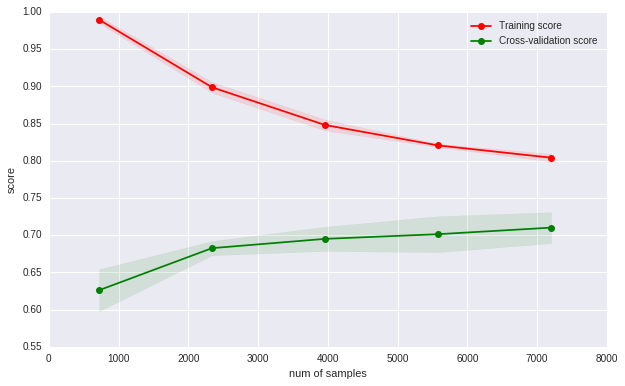

Best cross-validation result (0.71) obtained for 7200 


In [127]:
_X_train, _, _y_train, __ = train_test_split(X_train, y_train, stratify=y_train, train_size=0.3, random_state=seed)

train_learning_curve(_X_train, _y_train, default_params=default_params)

**  Compare with results of cross-validation. The bottom line is different, but the results are quite acceptable**

In [128]:
cv_results = cross_validation(_X_train, _y_train, num_rounds=23)
cv_results.tail(5)

Will train until cv error hasn't decreased in 5 rounds.
Stopping. Best iteration:
[7] cv-mean:0.7163726	cv-std:0.017247193541


,test-auc-mean,test-auc-std,train-auc-mean,train-auc-std
3,0.692284,0.017534,0.727096,0.005797
4,0.702634,0.016866,0.740776,0.005643
5,0.711694,0.019528,0.751302,0.002502
6,0.715813,0.020229,0.757329,0.002340
7,0.716373,0.017247,0.762519,0.002973


##### Take 50% of the original sample

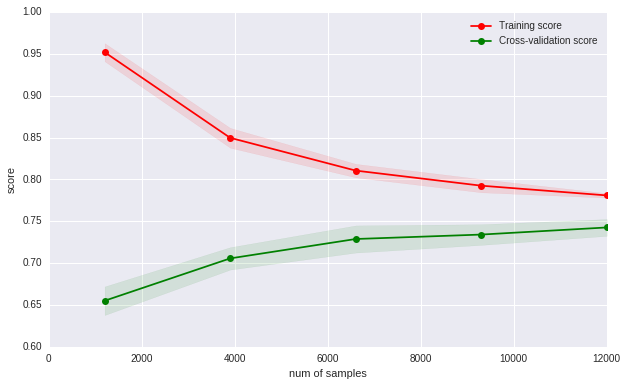

Best cross-validation result (0.74) obtained for 12000 


In [129]:
_X_train, _, _y_train, __ = train_test_split(X_train, y_train, stratify=y_train, train_size=0.5, random_state=seed)

train_learning_curve(_X_train, _y_train, default_params=default_params)

** Compare with results of cross-validation.**

In [131]:
cv_results = cross_validation(_X_train, _y_train, num_rounds=23)
cv_results.tail(5)

Will train until cv error hasn't decreased in 5 rounds.
Stopping. Best iteration:
[11] cv-mean:0.7382426	cv-std:0.0111096279434


,test-auc-mean,test-auc-std,train-auc-mean,train-auc-std
7,0.728409,0.009175,0.755931,0.003308
8,0.730161,0.012515,0.758456,0.001953
9,0.734516,0.011563,0.760973,0.002775
10,0.736371,0.010152,0.763664,0.003440
11,0.738243,0.011110,0.765145,0.002992


##### Take 80% of the original sample

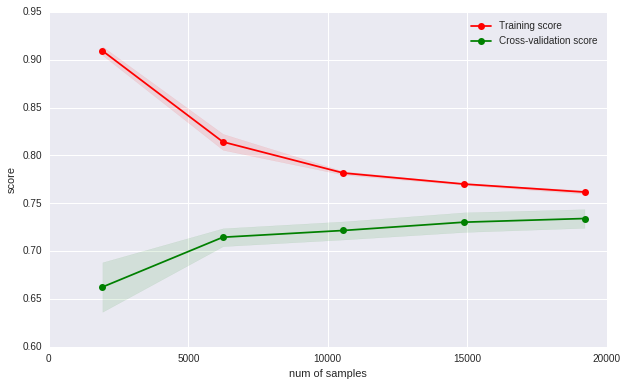

Best cross-validation result (0.73) obtained for 19200 


In [132]:
_X_train, _, _y_train, __ = train_test_split(X_train, y_train, stratify=y_train, train_size=0.8, random_state=seed)

train_learning_curve(_X_train, _y_train, default_params=default_params)

** Compare with results of cross-validation.**

In [133]:
cv_results = cross_validation(_X_train, _y_train, num_rounds=23)
cv_results.tail(5)

Will train until cv error hasn't decreased in 5 rounds.
Stopping. Best iteration:
[16] cv-mean:0.735579	cv-std:0.013683695875


,test-auc-mean,test-auc-std,train-auc-mean,train-auc-std
12,0.734929,0.014709,0.754417,0.003734
13,0.735509,0.014280,0.756223,0.003895
14,0.734509,0.014422,0.757784,0.003743
15,0.734741,0.013284,0.759509,0.003343
16,0.735579,0.013684,0.760926,0.003233


##### Take 100% of the original sample

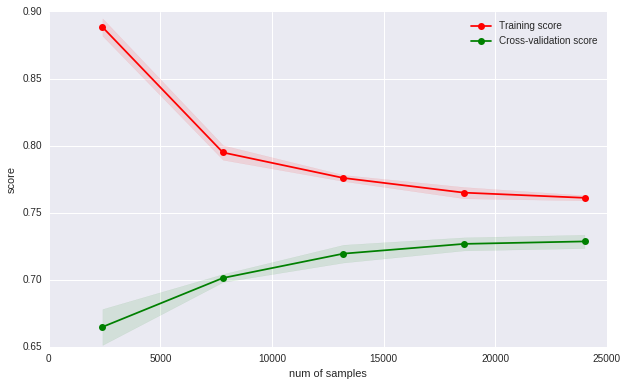

Best cross-validation result (0.73) obtained for 24000 
0    27768
1     2232
Name: labels, dtype: int64


In [134]:
train_learning_curve(X_train, y_train, default_params=default_params)
print y_train.value_counts()

** Compare with results of cross-validation.**

In [135]:
cv_results = cross_validation(X_train, y_train, num_rounds=23)
cv_results.tail(5)

Will train until cv error hasn't decreased in 5 rounds.


,test-auc-mean,test-auc-std,train-auc-mean,train-auc-std
18,0.738404,0.010040,0.759613,0.003995
19,0.738603,0.009488,0.760870,0.003812
20,0.739502,0.009892,0.762179,0.003802
21,0.740743,0.010233,0.763355,0.003825
22,0.740498,0.010019,0.764397,0.003947


** So, if we increase the sample assessment roc_auc is growing. Arrange this assessment the test of cruel reality - check it on hold-out sample**

In [36]:
params = {'objective': 'binary:logistic',
                  'max_depth': 2,
                  'learning_rate': 0.3,
                  'silent': 1,
                  'n_estimators': 23,
                  'scale_pos_weight':float(sum(y_train == 0))/sum(y_train == 1),
                  'seed': seed }

gtree = xgb.XGBClassifier(**params)
gtree.fit(X_train, y_train, eval_metric='auc')

print 'Hold-out set, roc-auc: ', roc_auc_score(y_hold_out, gtree.predict_proba(X_hold_out)[:, 1])

Hold-out set, roc-auc:  0.726616736833


#### 3.2 The elimination of the imbalance of classes by increasing the number of objects of a smaller class

** Often unbalanced classes samples lead to some problems while training the models. For instance model can fit perfectly the samples of biggest class and show good accuracy score, but recall score will be very poor.**

** Let's try to differentiate the sample, play with the distribution of objects into classes and conclude about how the class ratio affects the quality of the model. **

In [34]:
def oversample_x(data, labels, labels_x, amount_percents=1.0):
    rnd_indices = np.random.randint(0, len(labels_x), len(labels_x)*amount_percents) 
    
    new_df = pd.concat([data, data.ix[labels_x[rnd_indices]]], ignore_index=True)    
    new_lb = pd.concat([labels, labels.ix[labels_x[rnd_indices]]], ignore_index=True)
    new_df = pd.concat([new_df, new_lb], axis=1)
    # Shuffle
    new_df = pd.concat([new_df[:1], new_df[1:].sample(frac=1)]).reset_index(drop=True)     
    return new_df.iloc[:, :-1], new_df.iloc[:,-1]

def oversample_1(data, labels, amount_percents):
    label_idx = labels[labels == 1].index.values
    return oversample_x(data, labels, label_idx, amount_percents)
    
def oversample_0(data, labels, amount_percents):
    label_idx = labels[labels == 0].index.values
    return oversample_x(data, labels, label_idx, amount_percents)

#### Increase 3 times the number of classes of label "1"

Classes proportion
0    27768
1     8928
Name: labels, dtype: int64


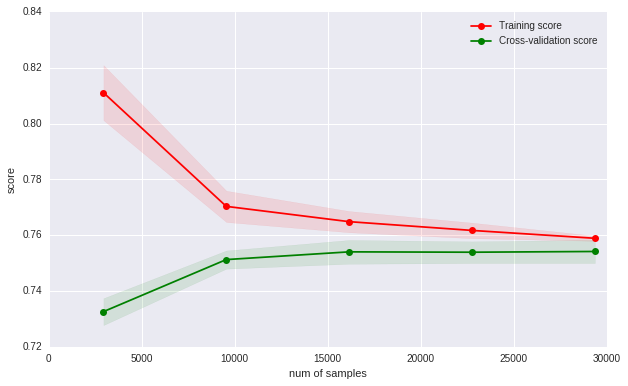

Best cross-validation result (0.75) obtained for 29356 


In [38]:
train_data_3, train_labels_3 = oversample_1(X_train, y_train, 3.0)

print 'Classes proportion\n', train_labels_3.value_counts()
train_learning_curve(train_data_3, train_labels_3, default_params=default_params)

** Compare with results of cross-validation.**

In [139]:
cv_results = cross_validation(train_data_3, train_labels_3, num_rounds=23)
cv_results.tail(5)

Will train until cv error hasn't decreased in 5 rounds.


,test-auc-mean,test-auc-std,train-auc-mean,train-auc-std
18,0.759443,0.007300,0.764671,0.000656
19,0.760227,0.006986,0.765460,0.001107
20,0.760787,0.006898,0.766162,0.001274
21,0.761417,0.006786,0.767002,0.001388
22,0.761910,0.006949,0.768039,0.001266


####  Increase 6 times the number of classes of label "1"

Classes proportion
0    27768
1    15624
Name: labels, dtype: int64


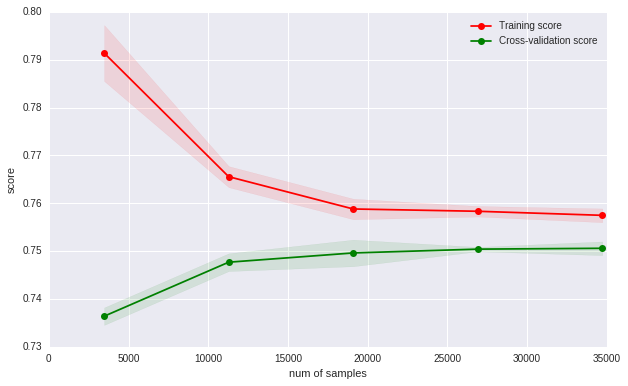

Best cross-validation result (0.75) obtained for 34713 


In [39]:
train_data_6, train_labels_6 = oversample_1(X_train, y_train, 6.0)

print 'Classes proportion\n', train_labels_6.value_counts()
train_learning_curve(train_data_6, train_labels_6, default_params=default_params)

** Compare with results of cross-validation.**

In [40]:
cv_results = cross_validation(train_data_6, train_labels_6, num_rounds=23)
cv_results.tail(5)

Will train until cv error hasn't decreased in 5 rounds.


,test-auc-mean,test-auc-std,train-auc-mean,train-auc-std
18,0.753811,0.008476,0.758837,0.000831
19,0.754428,0.008455,0.759629,0.001028
20,0.755277,0.008282,0.760924,0.001057
21,0.755780,0.008285,0.761712,0.001045
22,0.756787,0.008062,0.762790,0.001044


#### Raze the ratio of classes labeled "1" and "0"

Classes proportion
0    27768
1    27230
Name: labels, dtype: int64


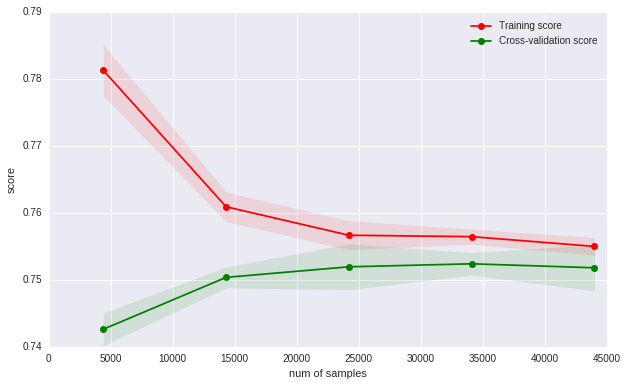

Best cross-validation result (0.75) obtained for 34098 


In [41]:
train_data_11, train_labels_11 = oversample_1(X_train, y_train, 11.2)

print u'Classes proportion\n', train_labels_11.value_counts()
train_learning_curve(train_data_11, train_labels_11, default_params=default_params)

** Compare with results of cross-validation.**

In [42]:
cv_results = cross_validation(train_data_11, train_labels_11, num_rounds=23)
cv_results.tail(5)

Will train until cv error hasn't decreased in 5 rounds.


,test-auc-mean,test-auc-std,train-auc-mean,train-auc-std
18,0.754425,0.002227,0.757008,0.000846
19,0.755627,0.002036,0.758210,0.000750
20,0.756050,0.002195,0.758955,0.000589
21,0.756728,0.001851,0.759543,0.000653
22,0.757621,0.001969,0.760645,0.000541


** Compare with results on hold-out dataset. **

In [54]:
params = {'objective': 'binary:logistic',
                  'max_depth': 2,
                  'learning_rate': 0.3,
                  'silent': 1,
                  'n_estimators': 23,
                  'scale_pos_weight':float(sum(y_train == 0))/sum(y_train == 1),
                  'seed': 123 }

train_data_11, train_labels_11 = oversample_1(X_train, y_train, 11.0)

gtree = xgb.XGBClassifier(**params)
gtree.fit(train_data_11, train_labels_11, eval_metric='auc')

print 'Hold-out set, roc-auc: ', roc_auc_score(y_hold_out, gtree.predict_proba(X_hold_out)[:, 1])

Hold-out set, roc-auc:  0.716084190667


#### Conclusions:
As can be seen from the graphs of the cross-validation and cross-validation, the more data and the more balanced the sample is, the higher the score roc_auc, but the score on the hold-out sample is not so optimistic and makes it clear that increasing the number of the same data of a smaller class may lead to overfitting. Why is this happening? Maybe it's the fact that I have enable the option of balancing classes in XGBoost and because of this, the saturation of the sample the same data leads to overfitting. Switching on and off 'scale_pos_weight' parameter of XGBoost confirms that assumption.

#### 3.3 The elimination of the imbalance of classes by reducing the number of objects larger class

** Apply undersampling technique to sampling: for this you need to remove number of objects of larger class from the sample so that the classes proportion has changed. **

** Looking ahead I will say that after a little research I found out that the model is most mistaken for the objects, which had a lot of blanks. Moreover, such objects are among the class of "0". I think it will be convenient to reduce the number of objects larger class where there is likelyhood to make a mistake when you restore blanks. **

In [55]:
def get_fresh_data():    
    fresh_data = pd.read_csv('orange_small_churn_train_data.csv', index_col='ID')
    fresh_data.loc[fresh_data['labels'] == -1, 'labels'] = 0   
    return drop_empty(fresh_data)

def standart_fill_nans(data):
    df_new = data.copy(deep=True)
    num_features = df_new.select_dtypes(include=['float64', 'int64']).columns
    cat_features = df_new.select_dtypes(include=['object']).columns

    df_new[num_features] = df_new[num_features].fillna(0)
    df_new[cat_features] = df_new[cat_features].fillna('NaN').apply(lambda x: LabelEncoder().fit_transform(x))
    return df_new

In [56]:
def undersample_0(amount_nans=50): 
    new_df = get_fresh_data()
    train_data, train_labels = new_df.iloc[:, :-1], new_df.iloc[:,-1]
    
    labels_0_idx = train_labels[train_labels == 0].index
    to_drop_idxs = []
    
    for row in train_data.ix[labels_0_idx].iterrows():
        if row[1].isnull().sum() > amount_nans:
            to_drop_idxs.append(row[0])

    train_data, train_labels = train_data.drop(train_data.index[to_drop_idxs]), train_labels.drop(train_labels.index[to_drop_idxs])       
    return train_data, train_labels

#### Reduce the number of classes labeled "0" for objects with the number of blanks in the features of more than 40.

Classes proportion
0    33195
1     2976
Name: labels, dtype: int64


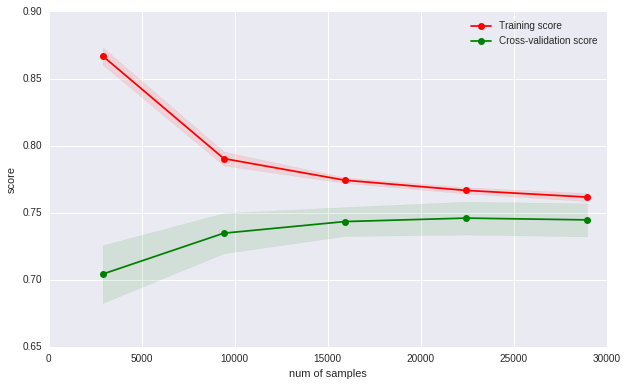

Best cross-validation result (0.75) obtained for 22425 


In [57]:
train_data_und_40, train_labels_und_40 = undersample_0(40)
train_data_und_40 = standart_fill_nans(train_data_und_40)

print u'Classes proportion\n', train_labels_und_40.value_counts()
train_learning_curve(train_data_und_40, train_labels_und_40, default_params=default_params)

** Compare with results of cross-validation.**

In [58]:
cv_results = cross_validation(train_data_und_40, train_labels_und_40, num_rounds=23)
cv_results.tail(5)

Will train until cv error hasn't decreased in 5 rounds.


,test-auc-mean,test-auc-std,train-auc-mean,train-auc-std
18,0.746587,0.007425,0.762132,0.001623
19,0.746736,0.007431,0.763265,0.001131
20,0.747840,0.006784,0.764294,0.001426
21,0.748618,0.006411,0.764855,0.001723
22,0.748127,0.006280,0.765758,0.001710


#### Reduce the number of classes labeled "0" for objects with the number of blanks in the features of more than 10.

Classes proportion
0    32195
1     2976
Name: labels, dtype: int64


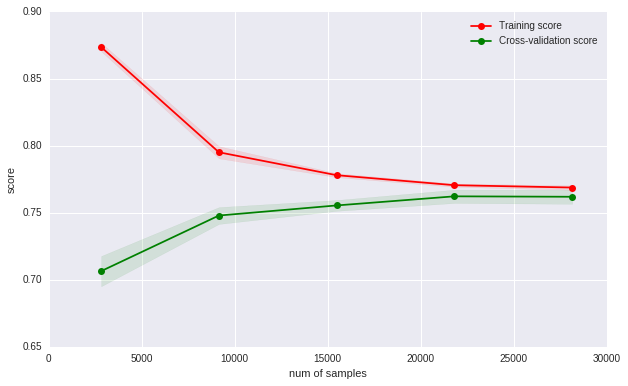

Best cross-validation result (0.76) obtained for 21805 


In [59]:
train_data_und_10, train_labels_und_10 = undersample_0(10)
train_data_und_10 = standart_fill_nans(train_data_und_10)

print u'Classes proportion\n', train_labels_und_10.value_counts()
train_learning_curve(train_data_und_10, train_labels_und_10, default_params=default_params)

** Compare with results of cross-validation.**

In [60]:
cv_results = cross_validation(train_data_und_10, train_labels_und_10, num_rounds=23)
cv_results.tail(5)

Will train until cv error hasn't decreased in 5 rounds.


,test-auc-mean,test-auc-std,train-auc-mean,train-auc-std
18,0.756499,0.008787,0.770654,0.001640
19,0.756922,0.009371,0.771690,0.001081
20,0.757258,0.009643,0.772568,0.001432
21,0.757905,0.009666,0.773301,0.001576
22,0.758529,0.009201,0.774593,0.001789


** Compare with results on hold-out dataset.**

In [169]:
params = {'objective': 'binary:logistic',
                  'max_depth': 2,
                  'learning_rate': 0.3,
                  'silent': 1,
                  'n_estimators': 23,
                  'seed': seed }

train_data_ho, train_labels_ho = undersample_0(10)
train_data_ho = standart_fill_nans(train_data_ho)

gtree = xgb.XGBClassifier(**params)
gtree.fit(train_data_ho, train_labels_ho, eval_metric='auc')

print 'Hold-out set, roc-auc: ', roc_auc_score(y_hold_out, gtree.predict_proba(X_hold_out)[:, 1])

Hold-out set, roc-auc:  0.673252412268


#### Conclusions:
Hold-out sample is put everything in its place. When reducing the number of blank objects, the greater the class quality decreases

#### 3.4 Blanks-filling for object separately by class

#### Let's try to fill in blanks in the classes "0" and "1" separately. My hypothesis is that different classes have different distributions in features and to restore such distributions is necessary separately

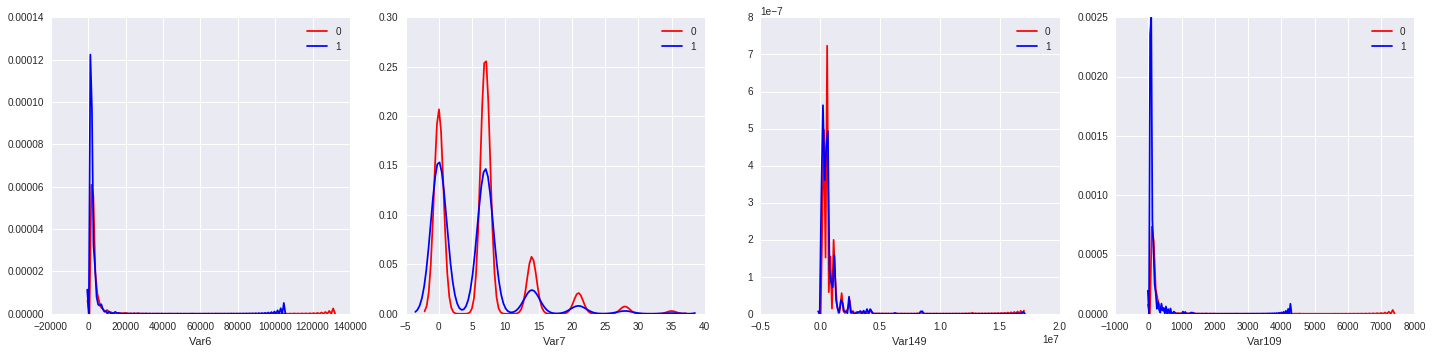

In [170]:
features_sample = ['Var6', 'Var7', 'Var149', 'Var109']
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
for i in xrange(4):
    sns.kdeplot(X_train.loc[y_train == 0, features_sample[i]], color = 'r', ax=axes[i], label=0)
    sns.kdeplot(X_train.loc[y_train == 1, features_sample[i]], color = 'b', ax=axes[i], label=1)
    axes[i].set(xlabel=features_sample[i])
fig.tight_layout()

** So, the graphs of the density distribution for randomly chosen features can be seen that even for balanced sampling density can vary. Let us restore the data separately by classes**

** Fill-in the numerical features blanks by average values **

In [174]:
new_df  = get_fresh_data()
train_data, train_labels = new_df.iloc[:, :-1], new_df.iloc[:,-1]

data_label_0 = train_data[train_labels==0]
data_label_1 = train_data[train_labels==1]

train_data[train_labels==0] = data_label_0[num_features].fillna(data_label_0[num_features].mean())
train_data[train_labels==1] = data_label_1[num_features].fillna(data_label_1[num_features].mean())

train_data[cat_features] = train_data[cat_features].fillna('NaN').apply(lambda x: LabelEncoder().fit_transform(x))

print 'Any values missing? ', train_data.isnull().values.any()
print 'Classes proportion\n', train_labels.value_counts()

Any values missing?  False
Class balance
0    37024
1     2976
Name: labels, dtype: int64


In [175]:
cv_results = cross_validation(train_data, train_labels, num_rounds=23)
cv_results.tail(5)

Will train until cv error hasn't decreased in 5 rounds.


,test-auc-mean,test-auc-std,train-auc-mean,train-auc-std
18,0.991810,0.001671,0.992377,0.000216
19,0.991796,0.001826,0.992519,0.000232
20,0.991969,0.001746,0.992694,0.000326
21,0.992225,0.001524,0.992955,0.000337
22,0.992254,0.001470,0.993027,0.000316


** Scale out numerical features. On one hand, scaling is very useful when working with linear models, and when working with trees may not help, but let's look at the result**

** Scale-out by RobustScaler, which can help if values in features have large emissions. **

In [178]:
new_df = get_fresh_data()
train_data, train_labels = new_df.iloc[:, :-1], new_df.iloc[:,-1]

data_label_0 = train_data[train_labels==0]
data_label_1 = train_data[train_labels==1]

train_data[train_labels==0] = data_label_0[num_features].fillna(0).apply(RobustScaler().fit_transform)
train_data[train_labels==1] = data_label_1[num_features].fillna(0).apply(RobustScaler().fit_transform)

train_data[cat_features] = train_data[cat_features].fillna('NaN').apply(lambda x: LabelEncoder().fit_transform(x))

print 'Any values missing? ', train_data.isnull().values.any()
print 'Classes proportion\n', train_labels.value_counts()

Any values missing?  False
Class balance
0    37024
1     2976
Name: labels, dtype: int64


** Cross-validation check.**

In [179]:
cv_results = cross_validation(train_data, train_labels, num_rounds=23)
cv_results.tail(5)

Will train until cv error hasn't decreased in 5 rounds.


,test-auc-mean,test-auc-std,train-auc-mean,train-auc-std
18,0.999819,0.000087,0.999876,0.000031
19,0.999860,0.000067,0.999896,0.000020
20,0.999865,0.000068,0.999904,0.000018
21,0.999881,0.000062,0.999917,0.000017
22,0.999880,0.000054,0.999920,0.000016


** Scale-out by StandardScaler, transforming data to a standard distribution **

In [181]:
new_df = get_fresh_data()
train_data, train_labels = new_df.iloc[:, :-1], new_df.iloc[:,-1]

data_label_0 = train_data[train_labels==0]
data_label_1 = train_data[train_labels==1]

train_data[train_labels==0] = data_label_0[num_features].fillna(0).apply(StandardScaler().fit_transform)
train_data[train_labels==1] = data_label_1[num_features].fillna(0).apply(StandardScaler().fit_transform)

train_data[cat_features] = train_data[cat_features].fillna('NaN').apply(lambda x: LabelEncoder().fit_transform(x))

print 'Any values missing? ', train_data.isnull().values.any()
print 'Classes proportion\n', train_labels.value_counts()

Any values missing?  False
Class balance
0    37024
1     2976
Name: labels, dtype: int64


** Cross-validation check.**

In [182]:
cv_results = cross_validation(train_data, train_labels, num_rounds=23)
cv_results.tail(5)

Will train until cv error hasn't decreased in 5 rounds.
Stopping. Best iteration:
[0] cv-mean:0.9994844	cv-std:0.000682405627175


,test-auc-mean,test-auc-std,train-auc-mean,train-auc-std
0,0.999484,0.000682,0.999832,0.000084


** As we can see, each of the tested methods may lead to overfitting of the model. We assume that the recovery by class not working. Confirm this fact with testing on hold-out sample **

In [209]:
new_df = get_fresh_data()
data, labels = new_df.iloc[:, :-1], new_df.iloc[:,-1]

num_features = data.select_dtypes(include=['float64', 'int64']).columns
cat_features = data.select_dtypes(include=['object']).columns

data[cat_features] = data[cat_features].fillna('NaN').apply(lambda x: LabelEncoder().fit_transform(x))

X_train, X_hold_out, y_train, y_hold_out = train_test_split(data, labels, test_size=0.25, 
                                                     random_state=seed, stratify=labels)

data_label_0 = X_train.loc[y_train==0, num_features]
data_label_1 = X_train.loc[y_train==1, num_features]

data_label_0 = data_label_0.fillna(data_label_0.mean())
data_label_1 = data_label_1.fillna(data_label_1.mean())

X_hold_out[num_features] = X_hold_out[num_features].fillna(X_hold_out[num_features].mean())

print 'Any values missing? ', X_hold_out.isnull().values.any()

params = {'objective': 'binary:logistic',
                  'max_depth': 2,
                  'learning_rate': 0.3,
                  'silent': 1,
                  'n_estimators': 23,
                  'scale_pos_weight':float(sum(y_train == 0))/sum(y_train == 1),
                  'seed': seed }

gtree = xgb.XGBClassifier(**params)
gtree.fit(X_train, y_train, eval_metric='auc')

print 'Hold-out set, roc-auc: ', roc_auc_score(y_hold_out, gtree.predict_proba(X_hold_out)[:, 1])

Any values missing?  False
Hold-out set, roc-auc:  0.719201755792


#### Conclusions:
Testing has shown that it is best to fill in the blanks with zeros. This is not surprising because if you look at the mode of our data, it is easy to see that the majority of numerical features the number with the highest frequency is number zero. However, the recovery features's blanks of the individual classes was not justified.

Scaling of numerical features has had little influence on the result.

#### 3.5 Comparison of strategies for encoding categorical features

** Before experiments with categorical features, let's look at their density distribution. This will help us to form hypotheses how to work with them and maybe it will become clear what categorical features better get rid of **

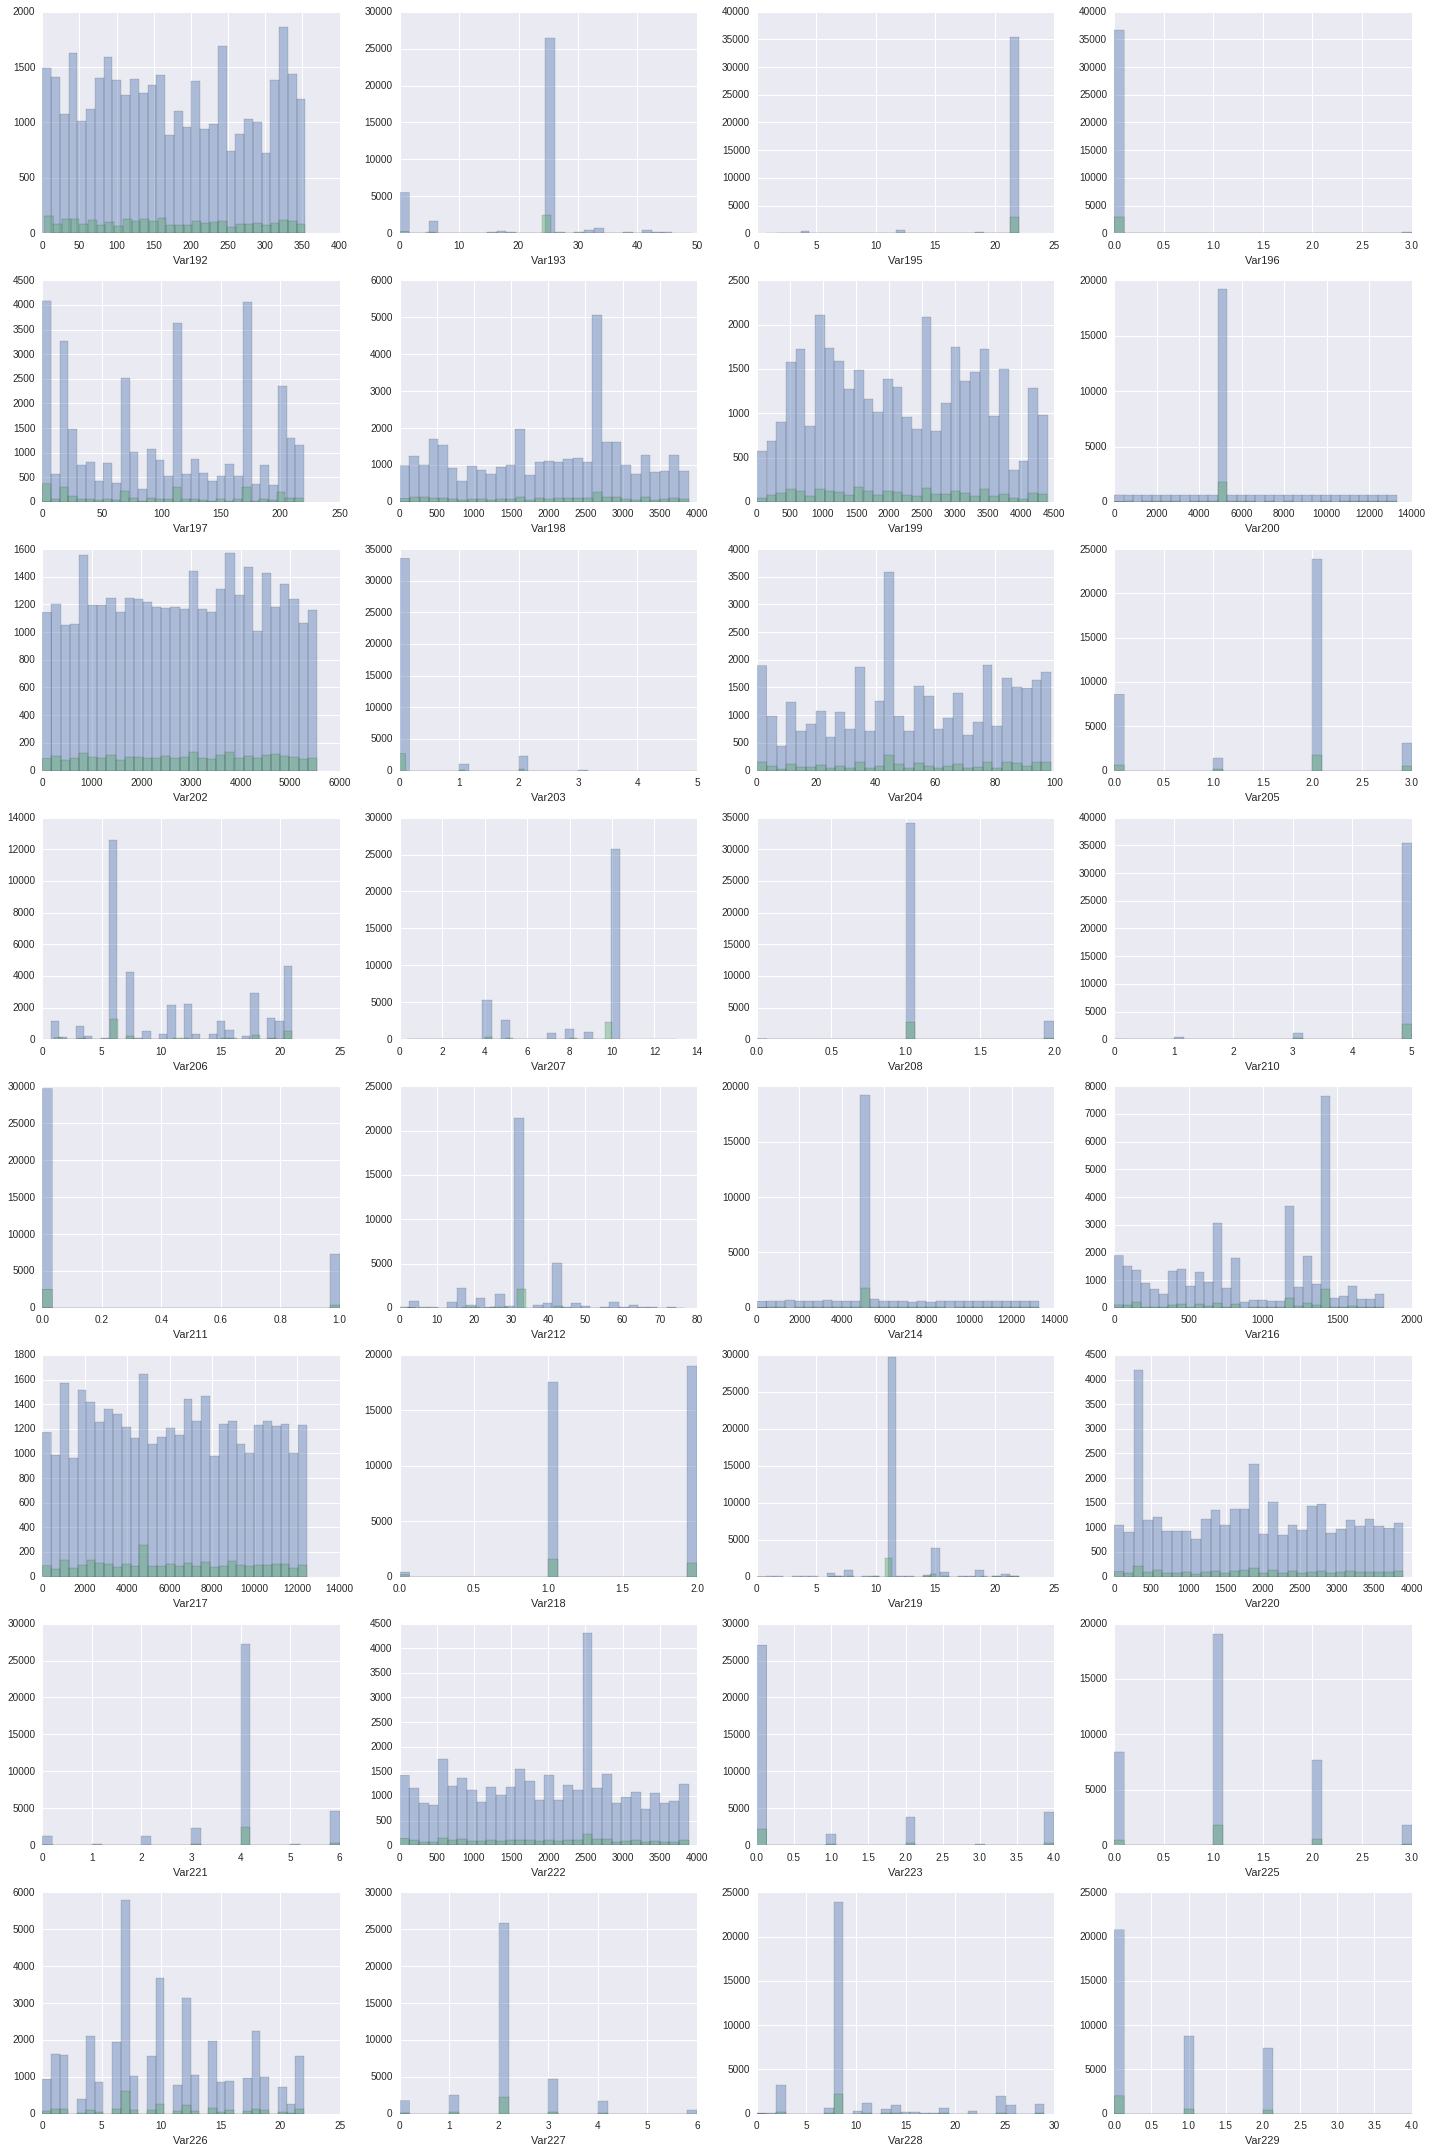

In [225]:
fig, axes = plt.subplots(8, 4, figsize=(20, 30))
for i in xrange(len(cat_features)):
    sns.distplot(data.loc[labels == 0, cat_features[i]], bins=30, kde=False, ax=axes[i / 4, i % 4], label='0')
    sns.distplot(data.loc[labels == 1, cat_features[i]], bins=30, kde=False, ax=axes[i / 4, i % 4], label='1')
    axes[i / 4, i % 4].set(xlabel=cat_features[i])
fig.tight_layout()

** Estimate values frequencies in categorical features.**

In [232]:
df[cat_features].describe()

,Var192,Var193,Var195,Var196,Var197,Var198,Var199,Var200,Var202,Var203,...,Var219,Var220,Var221,Var222,Var223,Var225,Var226,Var227,Var228,Var229
count,39709,40000,40000,40000,39877,40000,39996,19634,39999,39877,...,35804,40000,40000,40000,35804,19065,40000,40000,40000,17223
unique,354,50,23,4,220,3891,4400,13297,5542,5,...,22,3891,7,3891,4,3,23,7,30,4
top,1GdOj1KXzC,RO12,taul,1K8T,0Xwj,fhk21Ss,r83_sZi,yP09M03,nyZz,9_Y1,...,FzaX,4UxGlow,oslk,catzS2D,LM8l689qOp,ELof,FSa2,RAYp,F2FyR07IdsN7I,am7c
freq,313,28817,38353,39633,3688,3557,746,51,156,36192,...,32191,3557,29610,3557,29279,8875,6403,28112,26211,9312


** As we can see the number of unique values in some categories more than a few thousand: Var198, Var200, Var220, Var222 and others. Such number of unique values is not very helpfull in calculating the class to which the object belongs to and looks more like noise to be rid of. Remove features with number of categories greater than 30. **

** Code categorially features by using binarization, we introduce a separate feature-marker for empty values **

In [15]:
def get_cat_bin_data():
    new_df = get_fresh_data()
    train_data, train_labels = new_df.iloc[:, :-1], new_df.iloc[:,-1]

    num_features = train_data.select_dtypes(include=['float64', 'int64']).columns
    #feature-marker for empty values
    num_features_na = list(map(lambda name: name+'_na', num_features))
    
    train_data[num_features_na] = train_data[num_features].apply(lambda x: pd.isnull(x).astype(int))
    train_data[num_features] = train_data[num_features].fillna(0)

    cat_features = train_data.select_dtypes(include=['object']).columns
    
    to_drop = []
    for cat_col in cat_features:
        uniques = len(train_data[cat_col].unique())
        if uniques > 30:
            to_drop.append(cat_col)

    train_data = train_data.drop(to_drop, axis=1)
    cat_features = [col for col in cat_features if col not in to_drop] 
    
    # Binarizing of cat.+ na
    dummies_cat = pd.get_dummies(train_data[cat_features], dummy_na=True)

    train_data = train_data.drop(cat_features, axis=1)    
    train_data = pd.concat([train_data, dummies_cat], ignore_index=False, axis=1)

    return train_data, train_labels

In [64]:
train_data, train_labels = get_cat_bin_data()

print 'New shape:', train_data.shape

X_train, X_valid, y_train, y_valid = train_test_split(train_data, train_labels, test_size=0.25, 
                                                     random_state=seed, stratify=train_labels) 

print 'Any missing values? ', X_train.isnull().values.any()
print 'Classes proportion\n', y_train.value_counts()

cv_results = cross_validation(X_train, y_train, num_rounds=23)
cv_results.tail(5)

 New shape: (40000, 284)
Any missing values?  False
Classes proportion
0    27768
1     2232
Name: labels, dtype: int64


Will train until cv error hasn't decreased in 5 rounds.


,test-auc-mean,test-auc-std,train-auc-mean,train-auc-std
18,0.740105,0.011056,0.759684,0.003631
19,0.739834,0.010869,0.760454,0.003289
20,0.739806,0.010983,0.761435,0.003644
21,0.739880,0.010625,0.762803,0.003802
22,0.741283,0.011387,0.763909,0.003639


** The results on the hold-out sample with dummy coding quite a bit has fallen in comparison with LabelEncoder, but this result still does not figure. Things can change after selection of the parameters and setting the model, because now all the experiments going on basline**

In [65]:
params = {'objective': 'binary:logistic',
                  'max_depth': 2,
                  'learning_rate': 0.3,
                  'silent': 1,
                  'n_estimators': 23,
                  'scale_pos_weight':float(sum(y_train == 0))/sum(y_train == 1),
                  'seed': seed }


gtree = xgb.XGBClassifier(**params)
gtree.fit(X_train, y_train, eval_metric='auc')

print 'Hold-out set, roc-auc: ', roc_auc_score(y_valid, gtree.predict_proba(X_valid)[:, 1])

Hold-out set, roc-auc:  0.723218330917


## 4. Features analysis, selection of features

** All features have been useful to build models? Conduct the procedure of selecting features, try different options of selection.**

** For features selecting I will use several approaches. The first is already built into XGBoost is the ability to look at the importance of the features by the number of times when he was involved in the split. Second, is the selection K-best of features by Mutual Information or the Fisher test. The third is a greedy selection of features based on the model LogisticRegression.**

** Selection by XGBoost**


Optimal number of features : 40


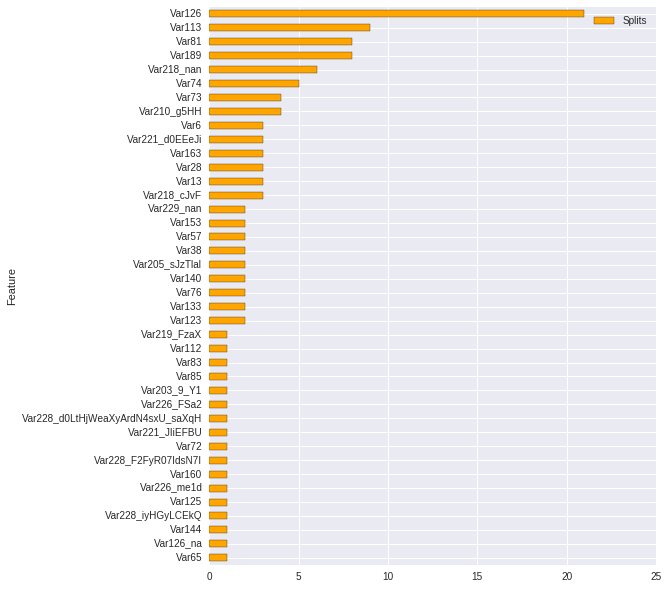

In [66]:
params = {'objective': 'binary:logistic',
                  'max_depth': 2,
                  'learning_rate': 0.3,
                  'silent': 1,
                  'n_estimators': 23,
                  'scale_pos_weight':float(sum(y_train == 0))/sum(y_train == 1),
                  'eval_metric':'auc',
                  'seed': seed }

dtrain = xgb.DMatrix(data=X_train, label=y_train, silent=False, feature_names=X_train.columns)
dtest = xgb.DMatrix(data=X_valid, label=y_valid, silent=False, feature_names=X_valid.columns)

watchlist  = [(dtest,'test'), (dtrain,'train')] 
# bst = xgb.train(params, dtrain, 40, watchlist)
bst = xgb.train(params, dtrain, 40)

importances = bst.get_fscore()
importance_df = pd.DataFrame({
        'Splits': list(importances.values()),
        'Feature': list(importances.keys())
    })
importance_df.sort_values(by='Splits', inplace=True)
importance_df.plot(kind='barh', x='Feature', figsize=(8,10), color='orange')
print "\nOptimal number of features : %d" % len(importances.values())

** Memorize the most important signs, that will come in handy in the future**

In [67]:
k_v = zip(importances.values(), importances.keys())
k_v.sort(key = lambda t: t[0], reverse=True)
kv_importances = [v[1] for v in k_v]
kv_importances

['Var126',
 'Var113',
 'Var81',
 'Var189',
 'Var218_nan',
 'Var74',
 'Var210_g5HH',
 'Var73',
 'Var28',
 'Var6',
 'Var221_d0EEeJi',
 'Var163',
 'Var218_cJvF',
 'Var13',
 'Var153',
 'Var123',
 'Var205_sJzTlal',
 'Var76',
 'Var133',
 'Var140',
 'Var38',
 'Var57',
 'Var229_nan',
 'Var65',
 'Var112',
 'Var226_FSa2',
 'Var85',
 'Var219_FzaX',
 'Var83',
 'Var203_9_Y1',
 'Var221_JIiEFBU',
 'Var72',
 'Var228_F2FyR07IdsN7I',
 'Var160',
 'Var226_me1d',
 'Var125',
 'Var228_iyHGyLCEkQ',
 'Var144',
 'Var126_na',
 'Var228_d0LtHjWeaXyArdN4sxU_saXqH']

In [20]:
params = {'objective': 'binary:logistic',
                  'max_depth': 2,
                  'learning_rate': 0.3,
                  'silent': 1,
                  'n_estimators': 23,
                  'seed': seed }

gtree = xgb.XGBClassifier(**params)
gtree.fit(X_train[kv_importances], y_train, eval_metric='auc')

print 'Hold-out set, roc-auc: ', roc_auc_score(y_valid, gtree.predict_proba(X_valid[kv_importances])[:, 1])

Hold-out set, roc-auc:  0.721969794658


**K-best selection of features by Mutual Information or the Fisher test**

In [489]:
params = {
'objective': 'binary:logistic', 
'max_depth': 2,
'learning_rate': 0.3,
'silent': True,
# 'scale_pos_weight':float(sum(y_train == 0))/sum(y_train == 1),
'n_estimators':23,
'seed': seed
}


pipeline = Pipeline([
('selector', SelectKBest()),
('boost', xgb.XGBClassifier(**params))
])


parameters_grid = {
    'selector__score_func': [f_classif, mutual_info_classif], 
    'selector__k': [90, 100, 120]
}

grid_cv = GridSearchCV(pipeline, parameters_grid, scoring='roc_auc', n_jobs=-1, 
                                                    cv = StratifiedShuffleSplit(n_splits=5,test_size=0.25,random_state=seed))

grid_cv.fit(X_train, y_train)
print u'Best AUC score: ', grid_cv.best_score_
print u'Best params: ',grid_cv.best_params_

Best AUC score:  0.741320351215
Best params:  {'selector__k': 90, 'selector__score_func': <function f_classif at 0x7f1a08593668>}


** Hold-out sample estimation**

In [23]:
params = {'objective': 'binary:logistic',
                  'max_depth': 2,
                  'learning_rate': 0.3,
                  'silent': True,
                  'n_estimators': 23,
                  'scale_pos_weight':float(sum(y_train == 0))/sum(y_train == 1),
                  'seed': seed }

kbest = SelectKBest(k=90, score_func=f_classif) 
X_train_kbest = kbest.fit_transform(X_train, y_train)
X_valid_kbest = kbest.transform(X_valid)

gtree = xgb.XGBClassifier(**params)
gtree.fit(X_train_kbest, y_train, eval_metric='auc')

print 'Hold-out set, roc-auc: ', roc_auc_score(y_valid, gtree.predict_proba(X_valid_kbest)[:, 1])

Hold-out set, roc-auc:  0.724746836693


** Finally, we will conduct a greedy selection of features with help of LogisticRegression**

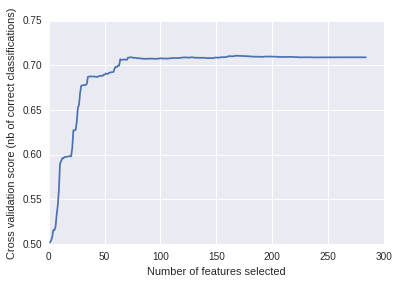

Optimal number of features : 169


In [70]:
from sklearn.linear_model import LogisticRegression

X_train_scaled = X_train
X_train_scaled[num_features] = RobustScaler().fit_transform(X_train[num_features])

rfecv = RFECV(estimator=LogisticRegression(class_weight='balanced'), 
              step=1, 
              cv=StratifiedShuffleSplit(n_splits=5,test_size=0.3,random_state=seed),
              scoring='roc_auc', 
              n_jobs=-1)
rfecv.fit(X_train_scaled, y_train)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

print("Optimal number of features : %d" % rfecv.n_features_)

In [71]:
selected_idxes = np.where( rfecv.support_ == True )
rfe_selected = X_train.columns.values[selected_idxes]
print rfe_selected

['Var7' 'Var21' 'Var22' 'Var73' 'Var113' 'Var126' 'Var144' 'Var189'
 'Var6_na' 'Var24_na' 'Var28_na' 'Var38_na' 'Var65_na' 'Var81_na'
 'Var109_na' 'Var119_na' 'Var126_na' 'Var140_na' 'Var144_na' 'Var149_na'
 'Var189_na' 'Var195_ArtjQZ8ftr3NB' 'Var195_ArtjQZQO1r9fC'
 'Var195_ArtjQZmIvr94p' 'Var195_BNjsq81k1tWAYigY' 'Var195_CiJDdr4TQ0rGERIS'
 'Var195_CuXi4je' 'Var195_F1JQrEL' 'Var195_I9xt3GBDKUbd8'
 'Var195_I9xt3GDRhUK7p' 'Var195_I9xt3GMcxUnBZ' 'Var195_I9xt3Gi01UK7p'
 'Var195_LfvqpCtLOY' 'Var195_TnJpfvsJgF' 'Var195_XMIgoIlPqx'
 'Var195_ZZBPiZh' 'Var195_b_3Q' 'Var195_bsZtYxFjzA' 'Var195_ev6I'
 'Var195_hiMqnEM7VgIk4JUu' 'Var195_lSbpiq1' 'Var195_taul' 'Var196_1K8T'
 'Var196_JA1C' 'Var203_HLqf' 'Var203_dgxZ' 'Var203_nan' 'Var205_09_Q'
 'Var205_VpdQ' 'Var205_sJzTlal' 'Var206_409L' 'Var206_69fI' 'Var206_6JmL'
 'Var206_CoYW' 'Var206_G_zk' 'Var206_TIA9' 'Var206_giwq' 'Var206_hzlB'
 'Var206_itlM' 'Var206_lVqb' 'Var206_oZyB' 'Var206_sYC_' 'Var206_wMei'
 'Var206_y6dw' 'Var206_nan' 'Var207_0MCPoln' 

In [74]:
params = {'objective': 'binary:logistic',
                  'max_depth': 2,
                  'learning_rate': 0.3,
                  'silent': True,
                  'n_estimators': 23,
                  'scale_pos_weight':float(sum(y_train == 0))/sum(y_train == 1),
                  'seed': seed }

gtree = xgb.XGBClassifier(**params)
gtree.fit(X_train[rfe_selected], y_train, eval_metric='auc')

print 'Hold-out set, roc-auc: ', roc_auc_score(y_valid, gtree.predict_proba(X_valid[rfe_selected])[:, 1])

Hold-out set, roc-auc:  0.5685238462


** Conclusions: **
So, different approaches have selected different number of features and showed different results on the hold-out sample. Greedy selection, **169, auc: 0.5685**, selection by splits in the XGBoost - **40, auc: 0.7219**. SelectKBest using Fisher **90, auc: 0.7247**. 

##  5. Model customizing

** Select the optimal model parameters. Note that depending on how you processed the raw data, did the class balancing, how many objects are left in the training set, the optimal values of the parameters can be changed. Take the best of decisions at the moment, and will carry out the procedure of selection of parameters of the model using hyperopt. **

In [26]:
from hyperopt import hp
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials


def score(params):
    xgb_tree = xgb.XGBClassifier(**params)
    
    eval_set = [(X_train, y_train), (X_valid, y_valid)] 

    xgb_tree.fit(X_train, y_train,
            eval_set=eval_set, eval_metric="auc", 
            early_stopping_rounds=30, verbose=False)

    pred = xgb_tree.predict_proba(X_valid)[:,1]
    auc = roc_auc_score(y_valid, pred)
    
    return{'loss':1-auc, 'status': STATUS_OK }

def optimize(trials):
    space = {
             'n_estimators' : hp.choice('n_estimators', np.arange(10, 100, dtype=int)),
             'learning_rate' : hp.quniform('learning_rate', 0.025, 0.5, 0.025),
             'max_depth' : hp.choice('max_depth', np.arange(2, 8, dtype=int)),
             'min_child_weight' : hp.quniform('min_child_weight', 1, 6, 1),
             'subsample' : hp.quniform('subsample', 0.3, 0.8, 0.05),
             'gamma' : hp.quniform('gamma', 0.5, 1, 0.05),
             'colsample_bytree' : hp.quniform('colsample_bytree', 0.3, 0.8, 0.05),
             'objective': 'binary:logistic',
             'nthread' : 7,
             'silent' : 1,
             'scale_pos_weight':float(sum(y_train == 0))/sum(y_train == 1),   
             'seed': seed   
             }

    best = fmin(score, space, algo=tpe.suggest, trials=trials, max_evals=500)

    print best

trials = Trials()
optimize(trials)

{'colsample_bytree': 0.55, 'learning_rate': 0.1, 'min_child_weight': 6.0, 'n_estimators': 59, 'subsample': 0.65, 'max_depth': 2, 'gamma': 0.9500000000000001}


** Set the new, optimized default settings, test on hold-out sample our optimization is not made worse.**

In [73]:
params = {
    'objective': 'binary:logistic',
    'colsample_bytree': 0.55, 
    'learning_rate': 0.1, 
    'min_child_weight': 6.0, 
    'n_estimators': 59, 
    'subsample': 0.65, 
    'max_depth': 2, 
    'gamma': 0.95,
    'scale_pos_weight':12.44,
    'seed':seed
}
gtree = xgb.XGBClassifier(**params)
gtree.fit(X_train, y_train, eval_metric='auc')
predict_prb = gtree.predict_proba(X_valid)[:, 1]

print 'Hold-out set, roc-auc: ', roc_auc_score(y_valid, predict_prb)

Hold-out set, roc-auc:  0.618123466557


** As you can see to find the optimal settings with hyperopt on 300 iterations failed. You may want to increase the number of iterations to narrow down the number of parameters, but this time we are not going to do it **

#### 5.1 Investigation of objects that achieved the highest classification error

** Let's look at the objects. On what objects achieved the highest classification error? Are these objects have something in common? Can you see any patterns? Why the largest error is achieved at these facilities? In this case, "largest" error can be understood as the classification of an object with someone else's class with great certainty (high probability). **

In [75]:
gtree = xgb.XGBClassifier(**params)
gtree.fit(X_train, y_train, eval_metric='auc')
predict_prb = gtree.predict_proba(X_valid)[:, 1]

df_new = pd.concat([X_valid])

df_new['target'] = y_valid
df_new['prediction'] = pd.Series(gtree.predict(X_valid), index=X_valid.index)
df_new['prediction_proba'] = pd.Series(predict_prb, index=X_valid.index) 

df_new.head()


,Var6,Var7,Var13,Var21,Var22,Var24,Var25,Var28,Var35,Var38,...,Var228_xwM2aC7IdeMC0,Var228_nan,Var229_am7c,Var229_mj86,Var229_oJmt,Var229_sk2h,Var229_nan,target,prediction,prediction_proba
ID,,,,,,,,,,,,,,,,,,,,,
10619,868.0,7.0,396.0,88.0,110.0,2.0,72.0,166.56,0.0,0.0,...,0,0,0,1,0,0,0,1,0,0.359385
24896,1155.0,7.0,2176.0,256.0,320.0,2.0,80.0,452.40,0.0,3063684.0,...,0,0,0,0,0,0,1,0,0,0.310083
6597,189.0,0.0,0.0,20.0,25.0,0.0,0.0,186.64,0.0,722520.0,...,0,0,0,0,0,0,1,0,0,0.446431
39086,875.0,0.0,0.0,64.0,80.0,2.0,8.0,286.96,5.0,8694960.0,...,0,0,0,0,0,0,1,0,1,0.505361
3873,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0,0,0,0,0,0,1,0,0,0.133818


** Find the indices of objects which do not match the target label and the predicted label**

In [840]:
not_same=df_new[((df_new.target == 1) & (df_new.prediction == 0)) | ((df_new.target == 0) & (df_new.prediction == 1))]


** Investigate the behavior of the most important numerical features which have selected by the model. For this visualize the distribution of feature values. Blanks will be marked as it is noticeable, for example, by number -70 **

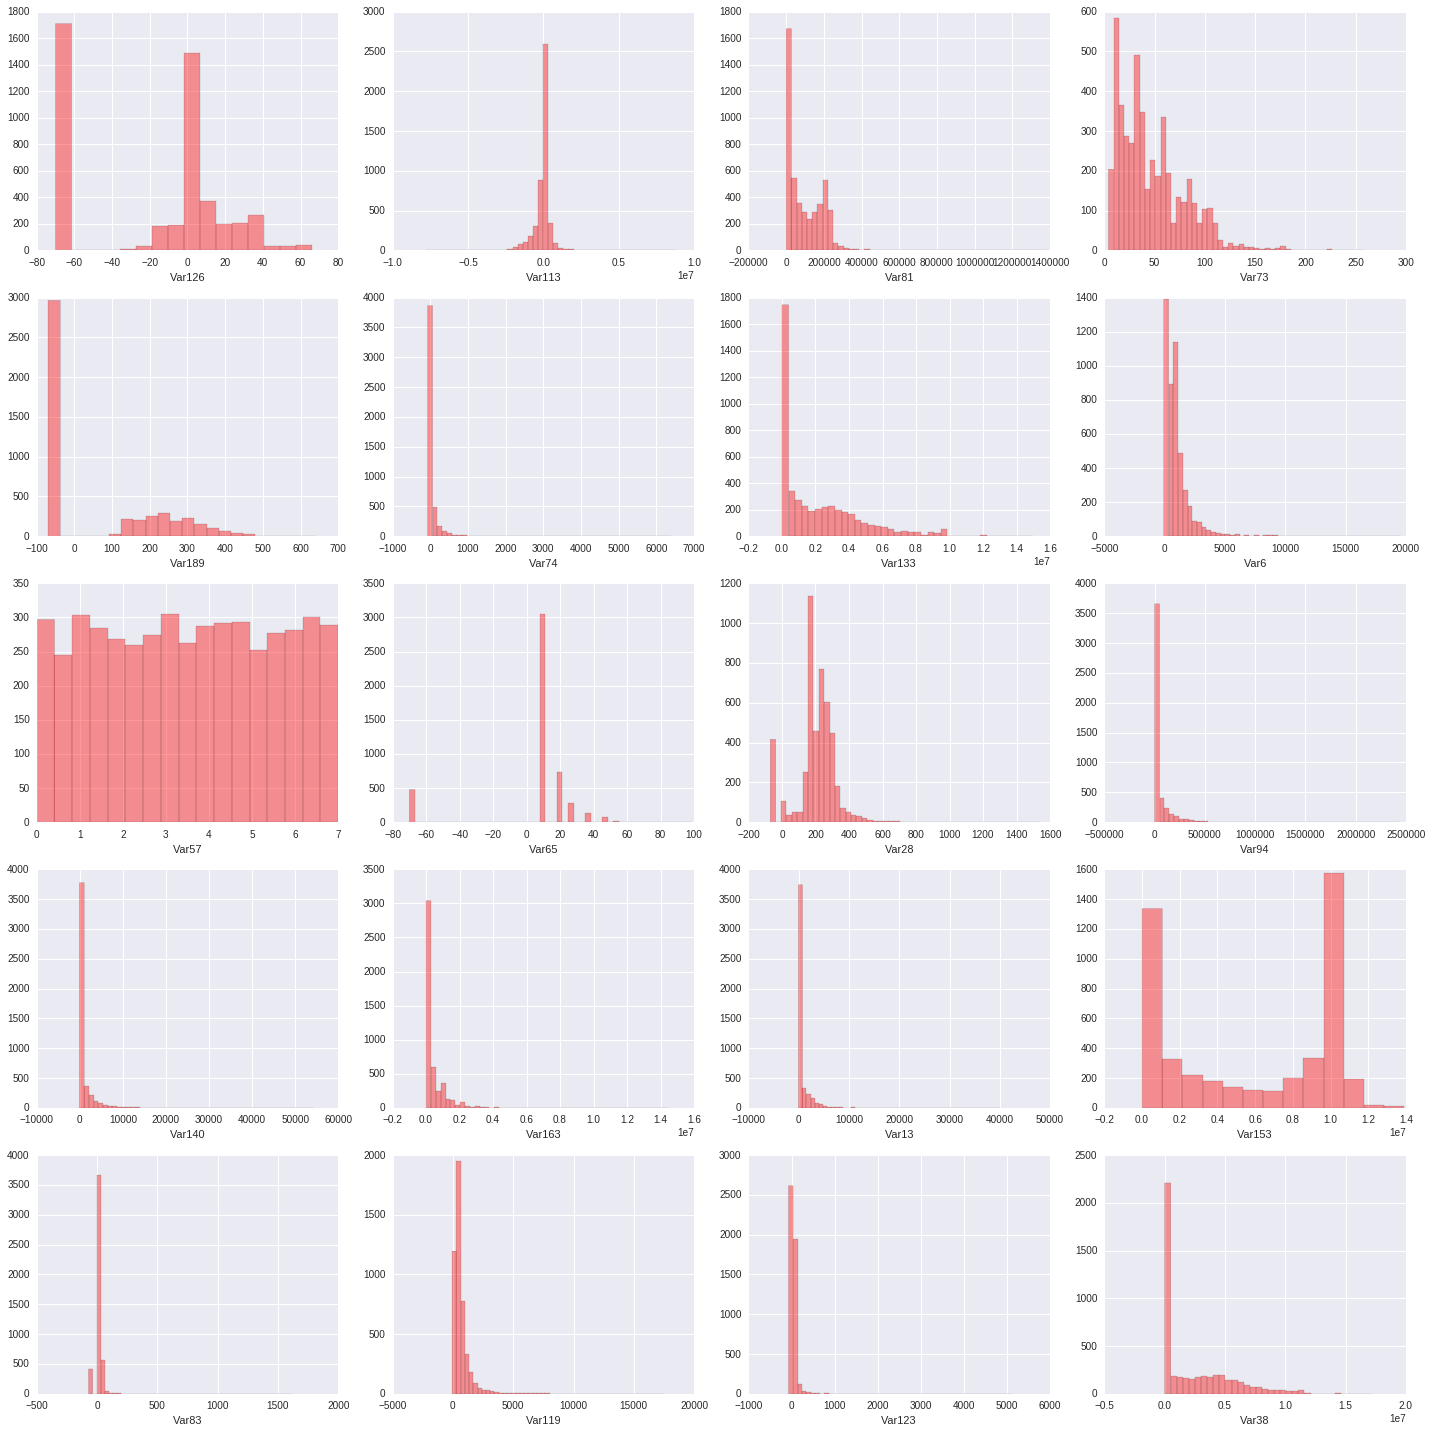

In [841]:
new_df, _ = get_fresh_data()
train_data, train_labels = new_df.iloc[:, :-1], new_df.iloc[:,-1]

num_features = ['Var126','Var113','Var81','Var73','Var189','Var74','Var133','Var6',
                 'Var57','Var65','Var28','Var94','Var140','Var163','Var13','Var153',
                 'Var83','Var119','Var123','Var38']

train_data[num_features] = train_data[num_features].fillna(-70)

fig, axes = plt.subplots(5, 4, figsize=(20, 20))
for i in range(len(num_features)):
    xx = train_data.ix[not_same.index][num_features[i]]
    sns.distplot(xx, kde=False,ax=axes[i / 4, i % 4], color = 'r', label='0')
    axes[i / 4, i % 4].set(xlabel=num_features[i])
fig.tight_layout()


** Conclusions: **

As can be seen from the distributions, the objects on which mistakes were made combine two things: 1. They have a lot of blanks 2. There are large emissions near zero. 

## 6. Future improvements

**Restoration of missing data:**

It seems to me, and it was repeatedly confirmed in the course of research - good data is everything! The main problem I faced is the correct restoration of blanks and work with distortions in the data distributions. I have considered not all methods and I think we should try others, for example Bayesian methods.

**Try other models:**

I like XGBoost and that's why I chose it as a base model for building experiments. But this does not mean that other models are bad. My experiments with undersampling, oversampling, data recovery by class, gave weak results of the experiments but to push me to the idea that these techniques may work poorly on gradient boosting only. But may well prove themselves in the linear models. 

Another example, which pushes me to think that you can try the linear model is an experiment with the binarize categorical features and pseudocategories numerical features. Such binarization works very well in LogisticRegression, but did not give a good gain in applying for XGBoost. 

In my experiments, I didn't use ensembles of models. Very often, especially in competitions on Kaggle, the models with different predictive abilities collected into one ensemble can give a significant improve in prediction score.

**Fine tuning of the model:**

If you look at the histogram of the importance of the features by which XGBoost did the splits and the distribution of values in these features, it becomes obvious that XGBoost somewhere too adjusted to these imbalances and we have to help him to process such data. How? I haven't decided yet, XGBoost is an extremely powerful tool to build a Gradient Boosting, but I invested far too little time to study and understand the nuances of his work. 

**New features generation:**

In my work I have generated new features mainly by binarizing category features and adding new feature as marker of blank value in the object. There are other approaches to the generation of new features, for example by using clustering, union of similar(correlated) features, features of frequency of the repetition of values in features and so on. All of above + the experiments with the different models can give an improvement of AUC.